# CSD 3: PCA

0. For this Case Study assignment you should have in your current folder the ebay_boys_girls_shirts folder, holding the four CSV files describing the train and test shirts images, and the boys and girls images folders. This is what we did in CSD 1, **if you already have the data in your current folder you don't need to run this again!**:

In [ ]:
import requests
import tarfile

url = "http://www.tau.ac.il/~saharon/DScourse/ebay_boys_girls_shirts.tar.gz"
r = requests.get(url)

with open("ebay_boys_girls_shirts.tar", "wb") as file:
    file.write(r.content)

with tarfile.open("ebay_boys_girls_shirts.tar") as tar:
    tar.extractall('.')

1. We would like to perform PCA on our girls and boys shirts images dataset. An image is a classic candidate for dimensionality reduction methods since even a colored 100x100 image has 30,000 features! (why?)

In CSD2 we learned how to read a random sample of images into a 4D numpy array. We defined the following functions:

In [1]:
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color, img_as_ubyte

%matplotlib inline

def get_file_list(df, folder, n_sample = None, seed = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample, random_state = seed).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = transform.resize(img, (w, h), mode='constant')
        img = img_as_ubyte(img)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :, :3]
    if img.shape != (1, 100, 100, 3):
        raise ValueError(f + str(img.shape))
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

Complete the `get_images_matrix` function **using the above functions** to unite what we did into a single function receiving `csv_file` path to the metadata CSV file, `folder` the name of the images folder and `n` sample size. See below for how the usage of this function to get `x_boys_train` and `x_girls_train`.

In [4]:
def get_images_matrix(csv_file, folder, n = None, seed = 1976):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n, seed)
    images = read_images_4d_array(files_list)
    return images, files_list

In [5]:
folder = 'ebay_boys_girls_shirts/'
x_boys_train, boys_files_list = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', 2000)
x_girls_train, girls_files_list = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', 2000)

print(x_boys_train.shape)
print(x_girls_train.shape)

(2000, 100, 100, 3)
(2000, 100, 100, 3)


2. Can you calculate the size of each of our 4D numpy arrays? Verify with this helper function:

In [6]:
def numpy_array_size_in_bytes(a):
    print(a.size * a.itemsize)

numpy_array_size_in_bytes(x_boys_train)

60000000


3. But we can't use our 4D arrays with PCA just yet. We need to:

(a) Reshape them as 2D arrays having N rows (images) X P columns (pixels)

In [7]:
def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

x_boys_train_all = get_all_pixels(x_boys_train)
x_girls_train_all = get_all_pixels(x_girls_train)

print(x_boys_train_all.shape)
print(x_girls_train_all.shape)

(2000, 30000)
(2000, 30000)


(b) Stack them one on top of the other, to have a giant `x_train` 2D numpy array, of size [4000, 30000].

Do that. Remember the docs, SO and good old Google (though once you get experience you're expected to know this yourself!).

In [8]:
x_train = np.vstack([x_boys_train_all, x_girls_train_all])

print(x_train.shape)

(4000, 30000)


4. As in class, we first center the `x_train` matrix:

In [9]:
x_train_centered = x_train - x_train.mean(axis = 0)

5. Can you calculate the `x_train_centered` matrix size in bytes? Use the `numpy_array_size_in_bytes` function to help you.

In [10]:
numpy_array_size_in_bytes(x_train_centered)

960000000


Does this result surprise you? Make sure you get this calculation.

6. How would you show that `x_train_centered` is indeed centered?

In [14]:
# many solutions here
print('x_train_centered first column sum: %.2f' % x_train_centered[:,0].sum())
print('x_train_centered first columns sums variance: %.2f' % np.var(x_train_centered.sum(axis=0)))

x_train_centered first column sum: -0.00
x_train_centered first columns sums variance: 0.00


7. As in class, we import `PCA` from [sklearn](https://scikit-learn.org/stable/) and fit it to data, asking for say first 10 PCs:

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)

pca.fit(x_train_centered)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

8. How would you get the `W` matrix of weights? (see class or the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html))

In [16]:
W = pca.components_
print(W.shape)

(10, 30000)


9. We multiply `x_train_centered` by `W` to get the reduced `x_train_reduced`:

In [17]:
x_train_reduced = np.matmul(x_train_centered, W.T)

print(x_train_reduced.shape)

(4000, 10)


10. What's the "sklearn" way of performing the last two stages?

In [18]:
x_train_reduced = pca.fit_transform(x_train_centered)

print(x_train_reduced.shape)

(4000, 10)


11. Let's compare boys and girls shirts images distribution of score on the first PC:

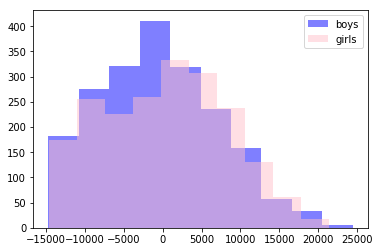

In [19]:
plt.hist(x_train_reduced[:2000, 0], alpha=0.5, label='boys', color = 'blue')
plt.hist(x_train_reduced[2000:, 0], alpha=0.5, label='girls', color = 'pink')
plt.legend(loc='upper right')
plt.show()

There doesn't seem to be a dramatic effect as we might have wanted, for better classification later on. Try this with other PCs, in our experience the 2nd PC captures "boys-like" vs. "girls-like" differences better.

12. Plot the images as points in a scatterplot (`plt.scatter`) of their score in the first PC vs. their score in the second PC. Use different colors for boys shirts images and for girls shirts images. You should get something like the below: 

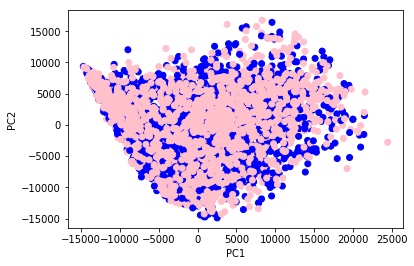

In [20]:
plt.scatter(x_train_reduced[:,0], x_train_reduced[:,1], color=['blue' for i in range(1000)] + ['pink' for i in range(1000)])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

13. Since we're dealing with images the best way to get what a given PC's "subject", what it is "talking about" is to simply to view those images which have a high or low score for this PC.

Which 16 images have the highest score for PC1?

In [21]:
highest_score_ids = np.argpartition(x_train_reduced[:, 0], -16)[-16:]
print(highest_score_ids)

[ 371 2738 1417 1702  389 3598 2000 1075 1667 2429 3248 3785 1758  830  775
  852]


Which 16 images have the lowest score for PC1?

In [22]:
lowest_score_ids = np.argpartition(x_train_reduced[:, 0], 16)[:16]
print(lowest_score_ids)

[ 693 2832 3430 1754 3154 2069 2075 3172  485  487  261 1920 3767 3779 3504
 2323]


We got the indices of the highest and lowest shirts images for PC1. How do we connect them back to the actual files so we can show them? If you recall when we sampled the images we also got the `boys_files_list` and `girls_files_list`.

In [23]:
all_files_list = np.array(boys_files_list + girls_files_list)

So the highest and lowest score files are:

In [24]:
highest_score_files = all_files_list[highest_score_ids]
lowest_score_files = all_files_list[lowest_score_ids]

highest_score_files

array(['ebay_boys_girls_shirts/boys/250.jpg',
       'ebay_boys_girls_shirts/girls/7386.jpg',
       'ebay_boys_girls_shirts/boys/3198.jpg',
       'ebay_boys_girls_shirts/boys/639.jpg',
       'ebay_boys_girls_shirts/boys/5579.jpg',
       'ebay_boys_girls_shirts/girls/11977.jpg',
       'ebay_boys_girls_shirts/girls/6574.jpg',
       'ebay_boys_girls_shirts/boys/15767.jpg',
       'ebay_boys_girls_shirts/boys/10791.jpg',
       'ebay_boys_girls_shirts/girls/8312.jpg',
       'ebay_boys_girls_shirts/girls/10011.jpg',
       'ebay_boys_girls_shirts/girls/6161.jpg',
       'ebay_boys_girls_shirts/boys/2522.jpg',
       'ebay_boys_girls_shirts/boys/14972.jpg',
       'ebay_boys_girls_shirts/boys/4909.jpg',
       'ebay_boys_girls_shirts/boys/11705.jpg'],
      dtype='<U38')

And now we can use our `read_images_4d_array` and `merge_images` functions from CSD2 to read these images and present them on a grid:

In [25]:
def merge_images(image_batch, size = [20, 20]):
    h,w = image_batch.shape[1], image_batch.shape[2]
    c = image_batch.shape[3]
    img = np.zeros((int(h*size[0]), w*size[1], c))
    for idx, im in enumerate(image_batch):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w,:] = im/255
    return img

highest_images = read_images_4d_array(highest_score_files)
lowest_images = read_images_4d_array(lowest_score_files)

highest_images_merged = merge_images(highest_images, size = [4, 4])
lowest_images_merged = merge_images(lowest_images, size = [4, 4])

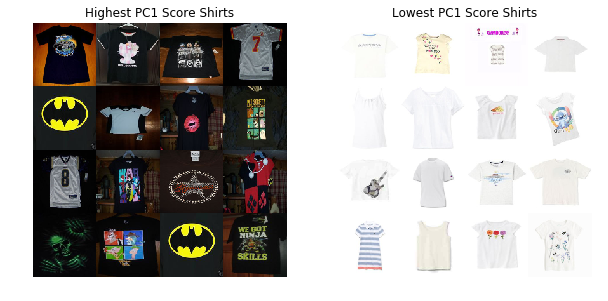

In [26]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Highest PC1 Score Shirts')
plt.axis('off')
plt.imshow(highest_images_merged)

plt.subplot(1, 2, 2)
plt.title('Lowest PC1 Score Shirts')
plt.axis('off')
plt.imshow(lowest_images_merged)

Well now it is quite clear what PC1 is all about...

14. Combine all of the above to a function called `plot_highest_lowest_on_PC` which would accept a PC number (0 to 9) and plot a 4x4 grid of the 16 shirts images with highest and lowest scores on this PC, side by side.

In [27]:
def plot_highest_lowest_on_PC(pc):
    highest_score_ids = np.argpartition(x_train_reduced[:, pc], -16)[-16:]
    lowest_score_ids = np.argpartition(x_train_reduced[:, pc], 16)[:16]
    highest_score_files = all_files_list[highest_score_ids]
    lowest_score_files = all_files_list[lowest_score_ids]
    highest_images = read_images_4d_array(highest_score_files)
    lowest_images = read_images_4d_array(lowest_score_files)

    highest_images_merged = merge_images(highest_images, size = [4, 4])
    lowest_images_merged = merge_images(lowest_images, size = [4, 4])
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title('Highest PC' + str(pc + 1) + ' Score Shirts')
    plt.axis('off')
    plt.imshow(highest_images_merged)

    plt.subplot(1, 2, 2)
    plt.title('Lowest PC' + str(pc + 1) + ' Score Shirts')
    plt.axis('off')
    plt.imshow(lowest_images_merged)

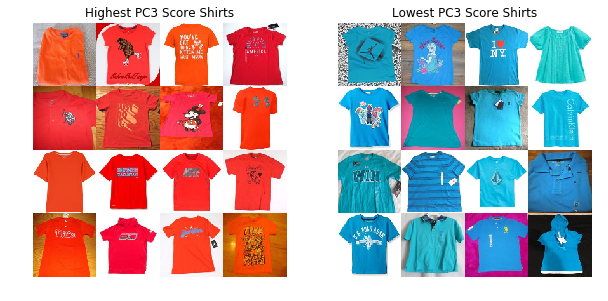

In [28]:
plot_highest_lowest_on_PC(2)